In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Using TensorFlow backend.
C:\Users\Manisha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Manisha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Manisha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Manisha\Anaconda3\lib\site-packages\tensorflow\python\framework\d

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [2]:
dataset = []
for folder in ["C:/Users/Manisha/Downloads/archive/set_a/**","C:/Users/Manisha/Downloads/archive/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1281 non-null   object 
 1   label     1281 non-null   object 
 2   offset    1281 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


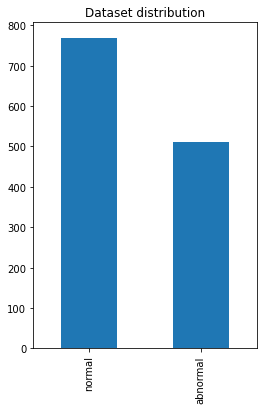

In [3]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [4]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1024
Test: 257


## Visualising the data and features

C:/Users/Manisha/Downloads/archive/set_b\normal__137_1306764999211_C.wav


C:\Users\Manisha\Anaconda3\lib\site-packages\librosa\display.py:831: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\Manisha\Anaconda3\lib\site-packages\librosa\display.py:831: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


C:/Users/Manisha/Downloads/archive/set_b\extrastole__220_1308250132896_B.wav


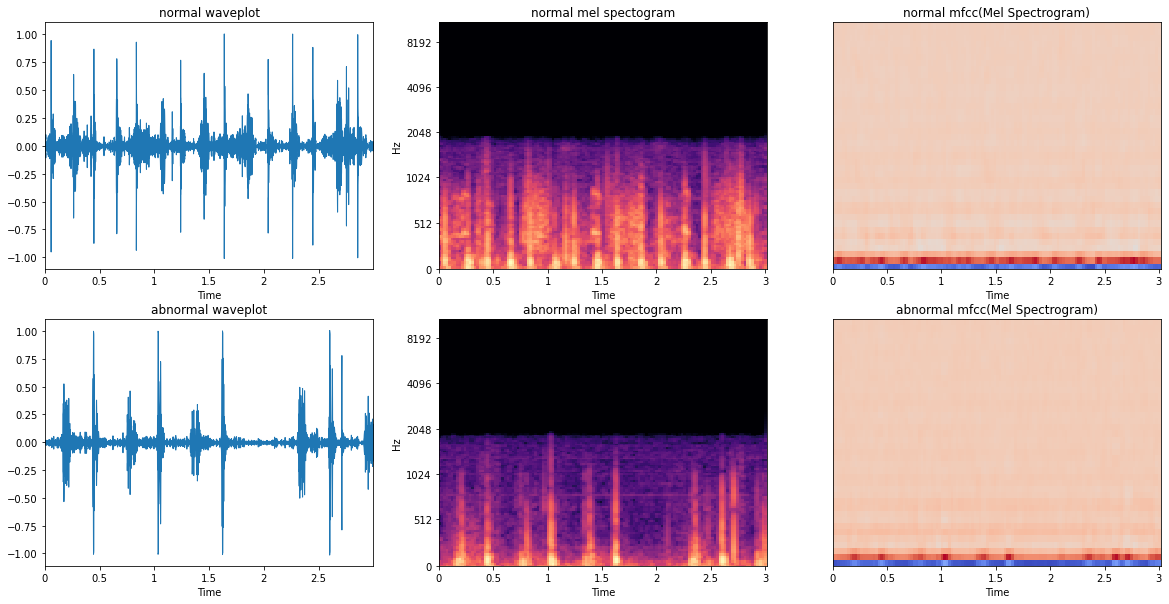

In [5]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc(Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [6]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [7]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [01:03<00:00,  4.07it/s]


X train: (1024, 40, 130)
X test: (257, 40, 130)


In [8]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

## Input Shapes

In [9]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1024, 40, 130, 1)
Y train: (1024, 2)
X test: (257, 40, 130, 1)
Y test: (257, 2)


## Building Model

In [10]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 39, 129, 16)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 63, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 31, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 31, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 30, 64)       

## Compiling Model

In [11]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

## Fitting Model

In [13]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)

Train on 1024 samples, validate on 257 samples
Epoch 1/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5189 - accuracy: 0.7471 - val_loss: 0.5115 - val_accuracy: 0.7704
Epoch 2/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5226 - accuracy: 0.7422 - val_loss: 0.5105 - val_accuracy: 0.7665
Epoch 3/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5216 - accuracy: 0.7422 - val_loss: 0.5191 - val_accuracy: 0.7743
Epoch 4/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5297 - accuracy: 0.7295 - val_loss: 0.5084 - val_accuracy: 0.7743
Epoch 5/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5090 - accuracy: 0.7432 - val_loss: 0.5110 - val_accuracy: 0.7588
Epoch 6/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5297 - accuracy: 0.7363 - val_loss: 0.5217 - val_accuracy: 0.7588
Epoch 7/300
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5196

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

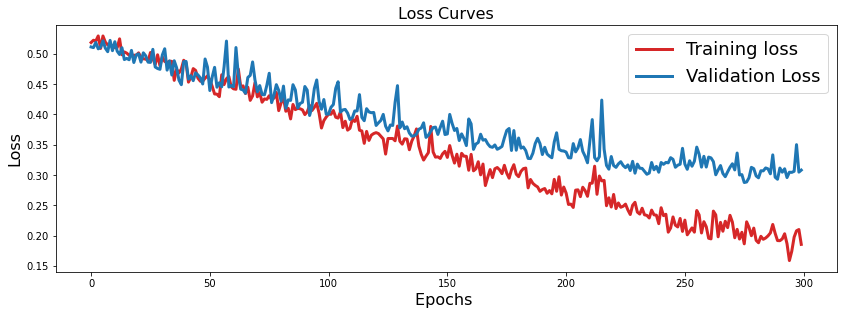

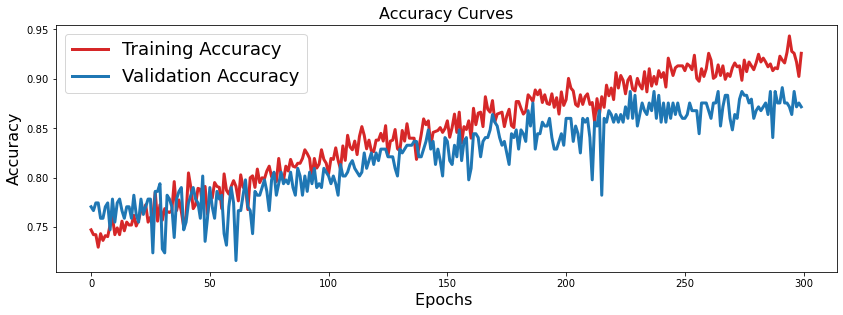

In [14]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [15]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

257/257 [==============================] - 0s 1ms/step
Test loss: 0.3081372818304407
Test accuracy: 0.8715953230857849


In [16]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

257/257 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    abnormal       0.87      0.83      0.85       113
      normal       0.87      0.90      0.89       144

    accuracy                           0.87       257
   macro avg       0.87      0.87      0.87       257
weighted avg       0.87      0.87      0.87       257



### Save Model and Weights

In [17]:
model_name = "heartbeat_classifier_binary_crossentropy.h5"
model.save(model_name)

In [18]:
# 1 sec overlap
# Trained for 3sec for files >3sec

### Classifying an heartbeat

In [81]:
# load and evaluate a saved model
from keras.models import load_model
 
# load model
model = load_model("heartbeat_classifier_binary_crossentropy.h5")

# File to be classified
classify_file = "C:/Users/Manisha/BE_Project/Physionet_Dataset/training/training-b/b0050.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

1/1 [==============================] - 2s 2s/step
[[0.96018386 0.03981618]]


In [83]:
################### ::WARNING:: ##########################
# print normal and abnormal are changed here
pred_class = model.predict_classes(x_test)
print(pred_class)
# if class=0: NORMAL
# if class=1: ABNORMAL
if pred_class[0]:
    print("Abnormal heartbeat")
    print("confidence:",pred[0][1])
else:
    print("Normal heartbeat")
    print("confidence:",pred[0][0])

[0]
Normal heartbeat
confidence: 0.96018386
